# EXPERIMENTAL
---
---

# MORBO-ENN: Multi-Objective Optimization

This notebook demonstrates multi-objective Bayesian optimization using the MORBO trust region with ENN surrogate.

---

In [1]:
import numpy as np

from enn.benchmarks import DoubleAckley

In [2]:
from enn.enn.enn_util import pareto_front_2d_maximize
from enn.turbo.hypervolume import hypervolume_2d_max


def compute_hypervolume(y: np.ndarray, ref_point: np.ndarray) -> float:
    y = np.asarray(y, dtype=float)
    if y.ndim != 2:
        raise ValueError(y.shape)
    if y.size == 0:
        return 0.0

    pareto_idx = pareto_front_2d_maximize(y[:, 0], y[:, 1])
    if pareto_idx.size == 0:
        return 0.0

    return hypervolume_2d_max(y[pareto_idx], ref_point)

In [3]:
import time

from enn import create_optimizer
from enn.turbo.optimizer_config import (
    OptimizerConfig,
    lhd_only_config,
    turbo_enn_config,
    turbo_one_config,
    turbo_zero_config,
)


def run_optimization(config: OptimizerConfig, name: str):
    num_dim = 30
    num_iterations = 100
    num_arms = 10
    noise = 0.1
    ref_point = np.array([-25.0, -25.0])

    rng = np.random.default_rng(18)
    objective = DoubleAckley(noise=noise, rng=rng)
    bounds = np.array([objective.bounds] * num_dim, dtype=float)

    optimizer = create_optimizer(bounds=bounds, config=config, rng=rng)

    all_y = []
    hypervolume_history = []
    proposal_times = []

    for iteration in range(num_iterations):
        t0 = time.time()
        x_arms = optimizer.ask(num_arms=num_arms)
        proposal_times.append(time.time() - t0)

        y_obs = objective(x_arms)
        optimizer.tell(x_arms, y_obs)

        all_y.append(y_obs)
        hv = compute_hypervolume(np.vstack(all_y), ref_point)
        hypervolume_history.append(hv)

        if iteration % 10 == 0:
            print(f"{name} iter {iteration:3d}: HV = {hv:.2f}")

    evals = num_arms * np.arange(1, len(hypervolume_history) + 1)
    return hypervolume_history, proposal_times, evals

In [4]:
import os

from enn.turbo.optimizer_config import (
    AcqType,
    CandidateGenConfig,
    CandidateRV,
    ENNFitConfig,
    ENNSurrogateConfig,
    MorboTRConfig,
    MultiObjectiveConfig,
)

RUN_TURBO_ONE = False

RUN_TURBO_ONE &= os.environ.get("FAST_TEST", "0") != "1"


k = 10
num_metrics = 2

sobol_candidates = CandidateGenConfig(candidate_rv=CandidateRV.SOBOL)
multi_objective = MultiObjectiveConfig(num_metrics=num_metrics)

configs = {
    "LHD_ONLY": lhd_only_config(
        trust_region=MorboTRConfig(multi_objective=multi_objective)
    ),
    "TURBO_ZERO": turbo_zero_config(
        trust_region=MorboTRConfig(multi_objective=multi_objective),
        candidate_rv=CandidateRV.SOBOL,
    ),
    "TURBO_ENN": turbo_enn_config(
        enn=ENNSurrogateConfig(k=k, fit=ENNFitConfig(num_fit_samples=100)),
        trust_region=MorboTRConfig(multi_objective=multi_objective, noise_aware=True),
        acq_type=AcqType.UCB,
        candidates=sobol_candidates,
    ),
}
if RUN_TURBO_ONE:
    configs["TURBO_ONE"] = turbo_one_config(
        trust_region=MorboTRConfig(multi_objective=multi_objective, noise_aware=True)
    )

results = {}
for name, config in configs.items():
    hv, times, evals = run_optimization(config, name)
    results[name] = {"hv": hv, "times": times, "evals": evals}

LHD_ONLY iter   0: HV = 19.75
LHD_ONLY iter  10: HV = 24.68
LHD_ONLY iter  20: HV = 24.80
LHD_ONLY iter  30: HV = 25.59
LHD_ONLY iter  40: HV = 26.66
LHD_ONLY iter  50: HV = 27.77
LHD_ONLY iter  60: HV = 28.80
LHD_ONLY iter  70: HV = 28.81
LHD_ONLY iter  80: HV = 28.83
LHD_ONLY iter  90: HV = 28.83
TURBO_ZERO iter   0: HV = 19.92
TURBO_ZERO iter  10: HV = 34.56
TURBO_ZERO iter  20: HV = 37.71
TURBO_ZERO iter  30: HV = 37.71
TURBO_ZERO iter  40: HV = 40.35
TURBO_ZERO iter  50: HV = 40.66
TURBO_ZERO iter  60: HV = 45.71
TURBO_ZERO iter  70: HV = 45.85
TURBO_ZERO iter  80: HV = 45.85
TURBO_ZERO iter  90: HV = 46.07
TURBO_ENN iter   0: HV = 19.92
TURBO_ENN iter  10: HV = 29.12
TURBO_ENN iter  20: HV = 35.51
TURBO_ENN iter  30: HV = 54.53
TURBO_ENN iter  40: HV = 55.62
TURBO_ENN iter  50: HV = 55.62
TURBO_ENN iter  60: HV = 55.62
TURBO_ENN iter  70: HV = 55.62
TURBO_ENN iter  80: HV = 56.86
TURBO_ENN iter  90: HV = 73.32


## Hypervolume vs Function Evaluations

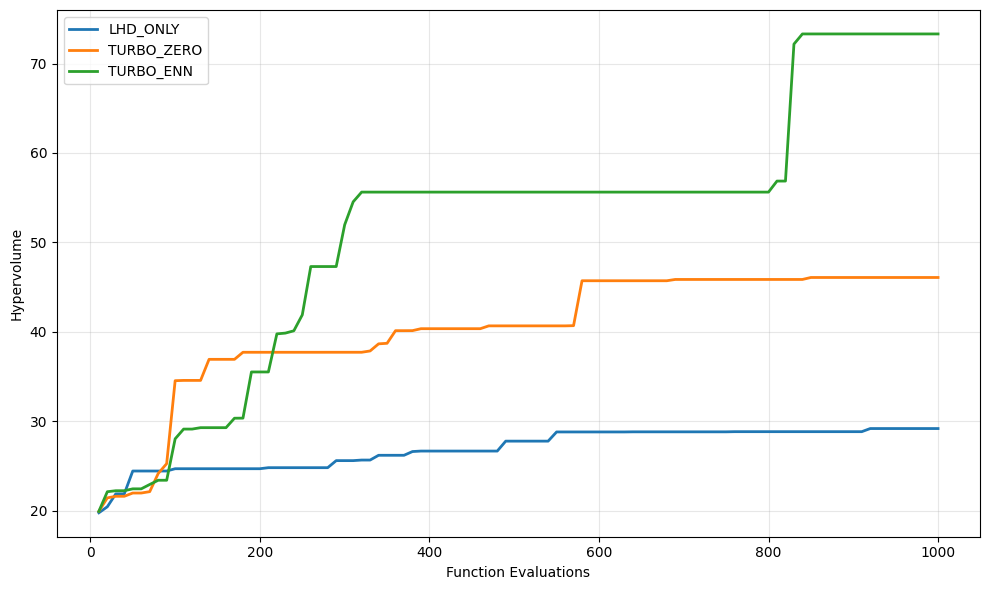

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for name, data in results.items():
    plt.plot(data["evals"], data["hv"], linewidth=2, label=name)
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Proposal Time vs Function Evaluations

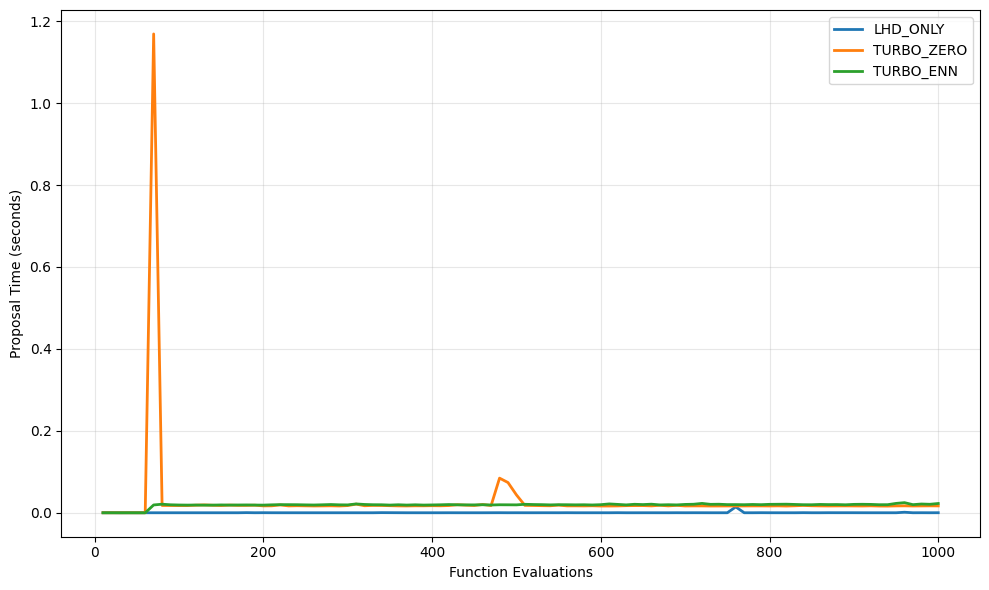

In [6]:
plt.figure(figsize=(10, 6))
for name, data in results.items():
    plt.plot(data["evals"], data["times"], linewidth=2, label=name)
plt.xlabel("Function Evaluations")
plt.ylabel("Proposal Time (seconds)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()